# Simulating the ground state of $H_2$

Let's explore how we can use zero-noise extrapolation to improve an estimation of the $H_2$ ground state energy.

## Dependencies

We'll start by importing a few dependencies.

In [2]:
# for loading execution context parameters from the environment
import os
from dotenv import load_dotenv

# for (de)serializing results
import json

# for processing data
import numpy as np

# for extrapolation
from scipy.optimize import curve_fit

# for plotting results
import matplotlib as mpl
import matplotlib.pyplot as plt

# for defining the circuits and observables constituting our expectation value problems
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal

# for using real quantum hardware
from qiskit import IBMQ, transpile
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService

Next, we'll import from the `zne` package
1. `ZNEStrategy`, which allows us to specify which noise amplifier, extrapolator, and noise factors to use for our experiment;
2. `Estimator`, which estimates our expectation value using ZNE on real hardware (we import it as `ZneEstimator` for clarity); and
3. `LocalFoldingAmplifier`, which is the noise amplifier we'll use for our experiment. 

In [2]:
from zne import ZNEStrategy
from zne import Estimator as ZneEstimator
from zne.noise_amplification import LocalFoldingAmplifier

## Execution Context

Let's set our execution context. We start by fetching the configuration from environment variables. Make sure to add a `.env` file in the same directory as this notebook with values for these environment variables before running the following cells.

Here's an example of what your `.env` file might look like:

```bash
TOKEN=6dc252b6700cd1297aa9936ca70f16c52326b6247fb6006dd2171d5845abeac86f7f265b20fd49e2098f4bec5b33d3805204f35c5463d4adf1994d41135bd80c
HUB=ibm-q
GROUP=open
PROJECT=main
BACKEND=ibmq_lima
```

In [3]:
load_dotenv()

TOKEN = os.environ["TOKEN"]

HUB = os.environ["HUB"]
GROUP = os.environ["GROUP"]
PROJECT = os.environ["PROJECT"]

BACKEND = os.environ["BACKEND"]

In [4]:
service = QiskitRuntimeService(channel="ibm_quantum", instance=f"{HUB}/{GROUP}/{PROJECT}", token=TOKEN)

In [5]:
IBMQ.enable_account(TOKEN)
provider = IBMQ.get_provider(hub=HUB, group=GROUP, project=PROJECT)
backend = provider.get_backend(BACKEND)

## Presentation Utilities

Next, let's configure how we want our plots to be drawn and define a few utility functions to help make plotting our results simpler.

In [19]:
mpl.rcParams['figure.dpi'] = 500
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Computer Modern Roman"
})

In [22]:
def plot_results(
    measured_data,
    exact_ev,
    experiment_repr,
    observable_repr,
    regime=None,
    regression_model=None,
    regression_guess=None,
    exact_color="#000000",
    measured_color="#dc267f",
    regression_color="#785ef0"
):
    if not regime: regime = len(measured_data["noise_factors"])

    noise_factors = np.array(measured_data["noise_factors"][:regime])
    measured_evs = np.array(measured_data["values"][:regime])
    measured_errors = np.sqrt(np.array(measured_data["variances"][:regime]) / np.array(measured_data["num_shots"][:regime]))

    plt.plot([0, noise_factors[regime-1]], [exact_ev, exact_ev], "--", label=f"Exact", color=exact_color)

    unmitigated_ev = measured_evs[0]
    unmitigated_error = np.abs(exact_ev - unmitigated_ev)
    plt.errorbar([1], measured_evs[0], yerr=measured_errors[0], label=f"Unmitigated ($\Delta\left\langle H \\right\\rangle = {unmitigated_error:.3f}$)", fmt="s", color=measured_color)

    plt.plot(noise_factors, measured_evs, label=f"Measured", color=measured_color)
    plt.fill_between(
        noise_factors,
        measured_evs - measured_errors,
        measured_evs + measured_errors,
        alpha=0.5,
        color=measured_color,
        linewidth=0
    )

    if regression_model:
        popt, pcov = curve_fit(regression_model, measured_data['noise_factors'][:regime], measured_data['values'][:regime], p0=regression_guess)
        goodness_of_fit = np.linalg.norm(np.diag(pcov))
        regression_domain = np.linspace(0, noise_factors[regime-1], 100)
        plt.plot(regression_domain, regression_model(regression_domain, *popt), label=f"Regression", color=regression_color)
        zne_ev = regression_model(0, *popt)
        zne_error = np.abs(exact_ev - zne_ev)
        plt.scatter([0], [zne_ev], label=f"Extrapolated ($\Delta\left\langle H \\right\\rangle = {zne_error:.3f}$)", marker="x", color=regression_color)

    plt.title(experiment_repr)
    plt.xlabel("Noise Factor ($n$)")
    plt.ylabel(f"Expectation Value ($\langle {observable_repr} \\rangle$)")
    plt.legend()
    plt.show()

## Define Experiment

Now we're ready to define our experiment! For our circuit, we'll take a `TwoLocal` ansatz and feed it the optimal parameters from a separate VQE experiment (not included here for the sake of brevity) to represent our H2 ground state wavefunction. For our observable, we can define the $H_2$ hamiltonian as a `SparsePauliOp`. Finally, we'll define the exact ground state energy.

In [7]:
H2_GNDSTATE_WAVEFN = QuantumCircuit(2).compose(
    TwoLocal(
        rotation_blocks=["ry", "rz"], entanglement_blocks="cz", num_qubits=2
    ).assign_parameters(
        [
            4.104009273873245,
            -6.046872443309065,
            5.277223342332378,
            1.5319564597237907,
            4.893000083985066,
            -3.0921586512224257,
            -0.34939132286472496,
            5.584790805066014,
            -4.161687737508674,
            -3.2391548739165845,
            1.7436977108208878,
            0.17441513089260774,
            2.623695306064223,
            0.03678956439381653,
            2.410055788777767,
            -2.3250358101154913,
        ]
    )
)

H2_HAMILTONIAN = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

H2_GNDSTATE_ENERGY = -1.85727503

Next, let's choose the noise factors we want to use for our experiment. Let's try as many noise factors as possible to saturate the noise profile, so we can explore extrapolation in various regimes. Depending on your experiment, you might need to play with the maximum noise factor to determine where the noise profile saturates (the expectation value flattens out and no longer seems to change as a function of the noise factor).

In [8]:
NOISE_FACTORS = tuple(range(1, 199 + 2, 2))
len(NOISE_FACTORS)

100

## Simulate Experiment

Let's confirm that the statevector simulator gives us our exact ground state energy using the `Estimator` from `qiskit.primitives`.

In [14]:
with Estimator([H2_GNDSTATE_WAVEFN], [H2_HAMILTONIAN]) as estimator:
  simulated_energy = estimator([0], [0]).values[0]
simulated_energy

-1.857275030184889

In [15]:
np.isclose(simulated_energy, H2_GNDSTATE_ENERGY)

True

Looks like we're good to go!

## Run Experiment

We start by spinning up a `ZneEstimator` and passing in our ground state wavefunction as the circuit and the hamiltonian as the observable. We also specify a `service` which houses our IBMQ credentials and a backend through the `options` dictionary. Finally, we pass in a `ZNEStrategy` with our sequence of noise factors and noise amplifier. 

Inside the `ZneEstimator` context, we call `estimator` with the indices of the circuit and the observable from the list we passed in at construction to compute the expectation value of our observable for our circuit.

Finally, we parse through the results and dump the data to a file. 

These lines are commented, so that you don't have to wait for the experiments to run. Instead, you can just load the experimental data from the file by running the cell as-is!

In [3]:
# with ZneEstimator(
#     circuits=[H2_GNDSTATE_WAVEFN],
#     observables=[H2_HAMILTONIAN],
#     service=service,
#     options={"backend": backend.name()},
#     zne_strategy=ZNEStrategy(noise_factors=NOISE_FACTORS, noise_amplifier=LocalFoldingAmplifier()),
# ) as estimator:
#     results = estimator(
#         circuits=[0],
#         observables=[0],
#     )

# data = {
#     "noise_factors": list(results.metadata[0]["zne"]["noise_factors"]),
#     "values": list(results.metadata[0]["zne"]["values"]),
#     "variances": list(results.metadata[0]["zne"]["variances"]),
#     "num_shots": [ result["shots"] for result in results.metadata[0]['zne']['remaining_metadata'] ]
# }

# with open('data.json', 'w') as f:
#     json.dump(data, f)

with open('data.json', 'r') as f:
    data = json.load(f)

## Plot Results

Great, now that we have our results— let's take a look!

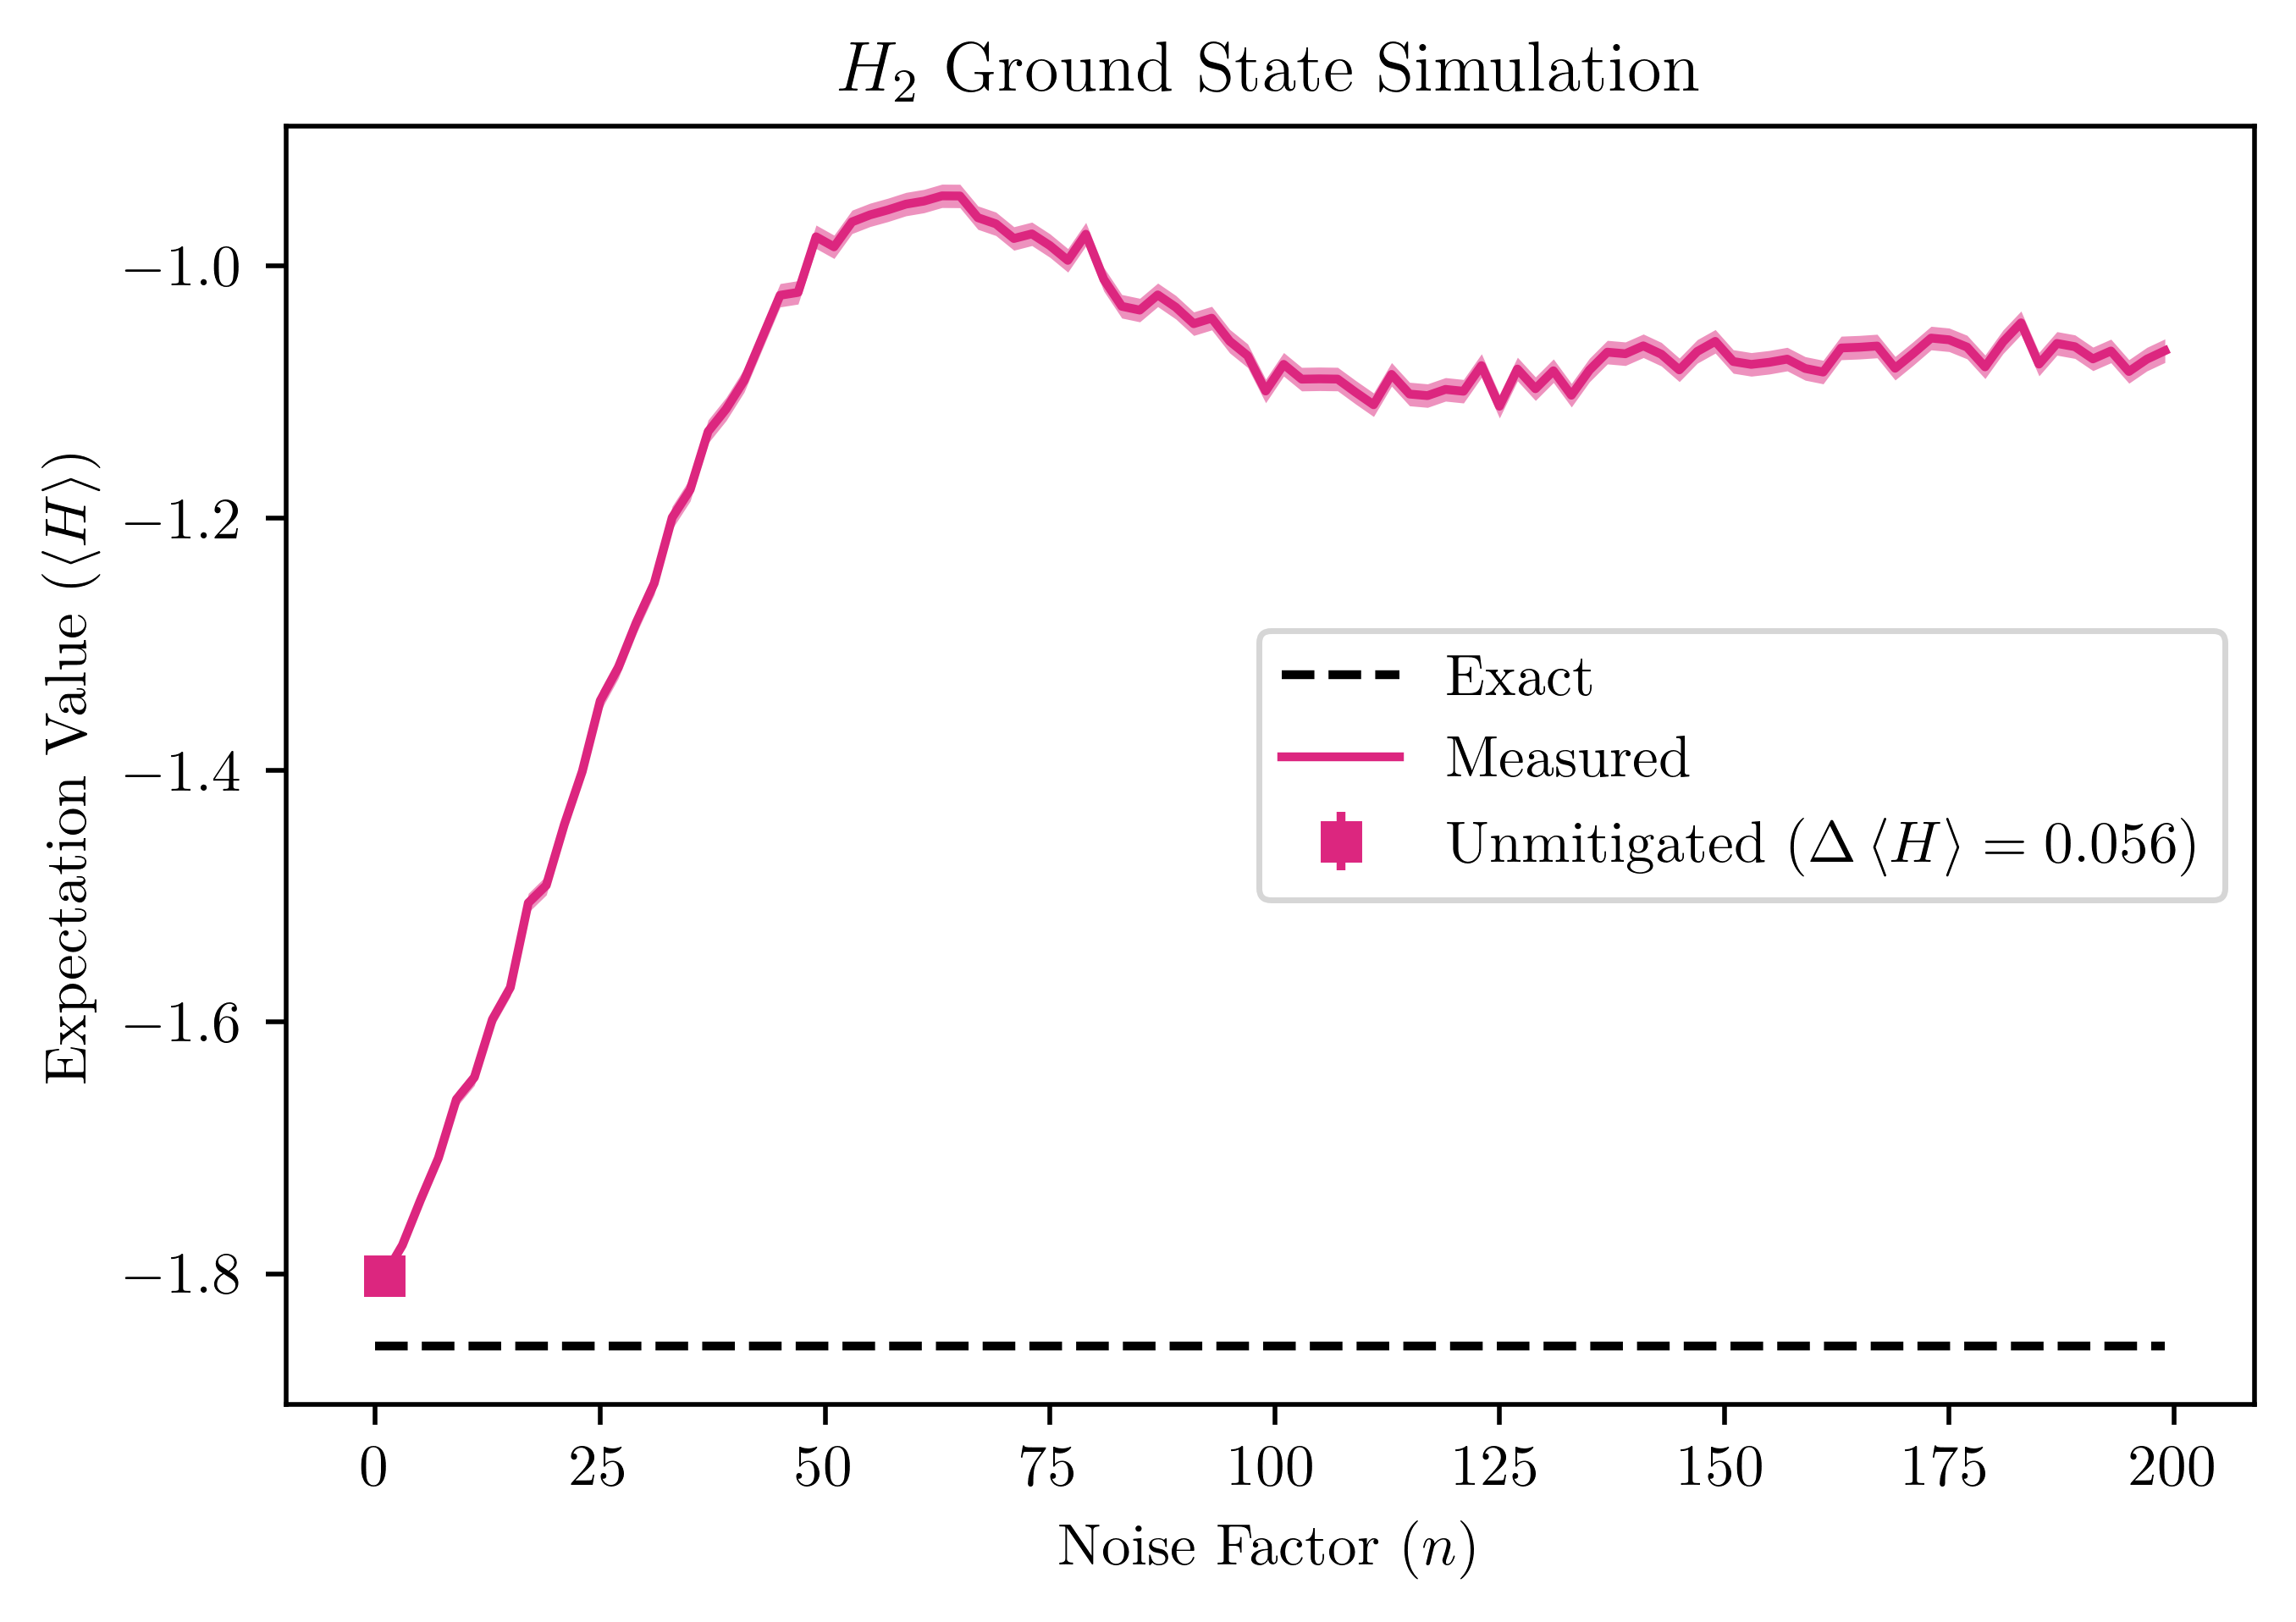

In [26]:
plot_results(data, H2_GNDSTATE_ENERGY, "$H_2$ Ground State Simulation", "H")

Looks the linear regime lasts until $n\approx50$, and the curve generally resembles an underdamped sinusoid. Let's start extrapolating!

## Extrapolation

For extrapolation, let's explore two regression models: a **linear** model and a **damped sinusoid** model. In `zne`, this process is taken care of by the `Extrapolator` class. We're not using it right now for flexibility and to explore internal details which would otherwise be difficult to extract.

### Linear Regression

We'll start by defining our linear model.

In [19]:
def linear(noise_factor, noiseless_ev, decay_rate):
    return noiseless_ev + decay_rate * noise_factor

Then, for various slices in the linear regime let's extrapolate to zero noise and take a look at the results.

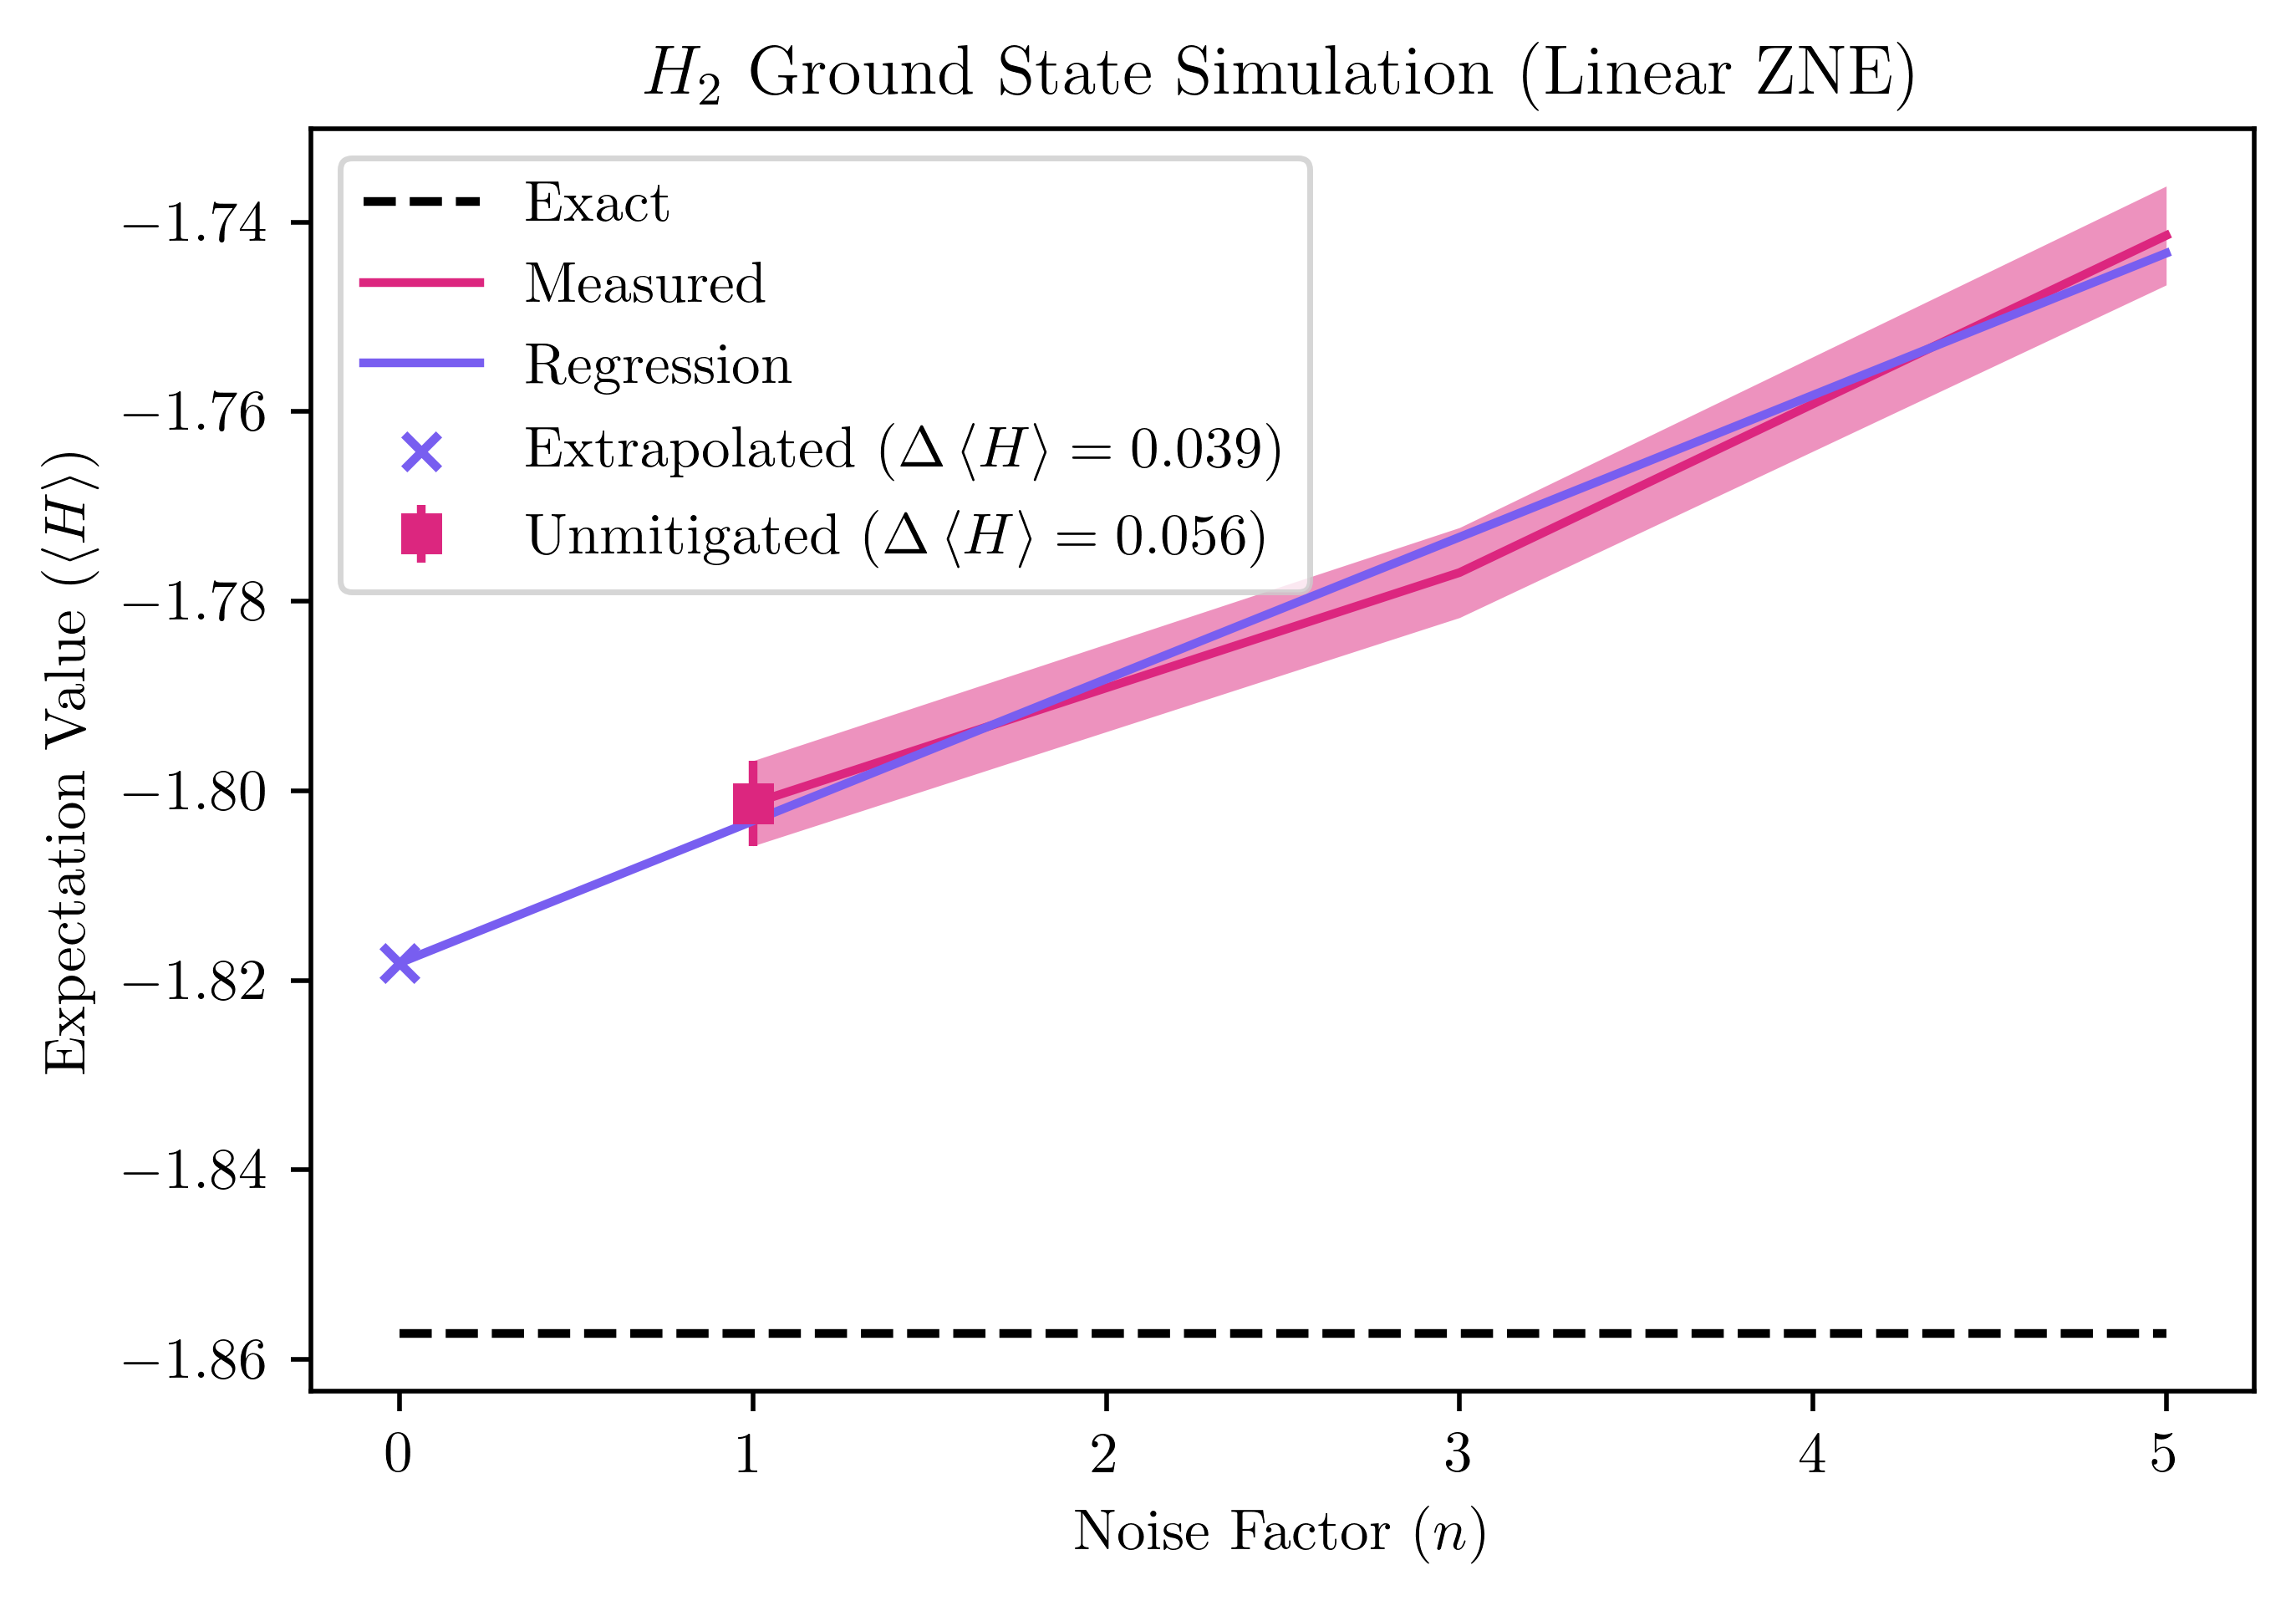

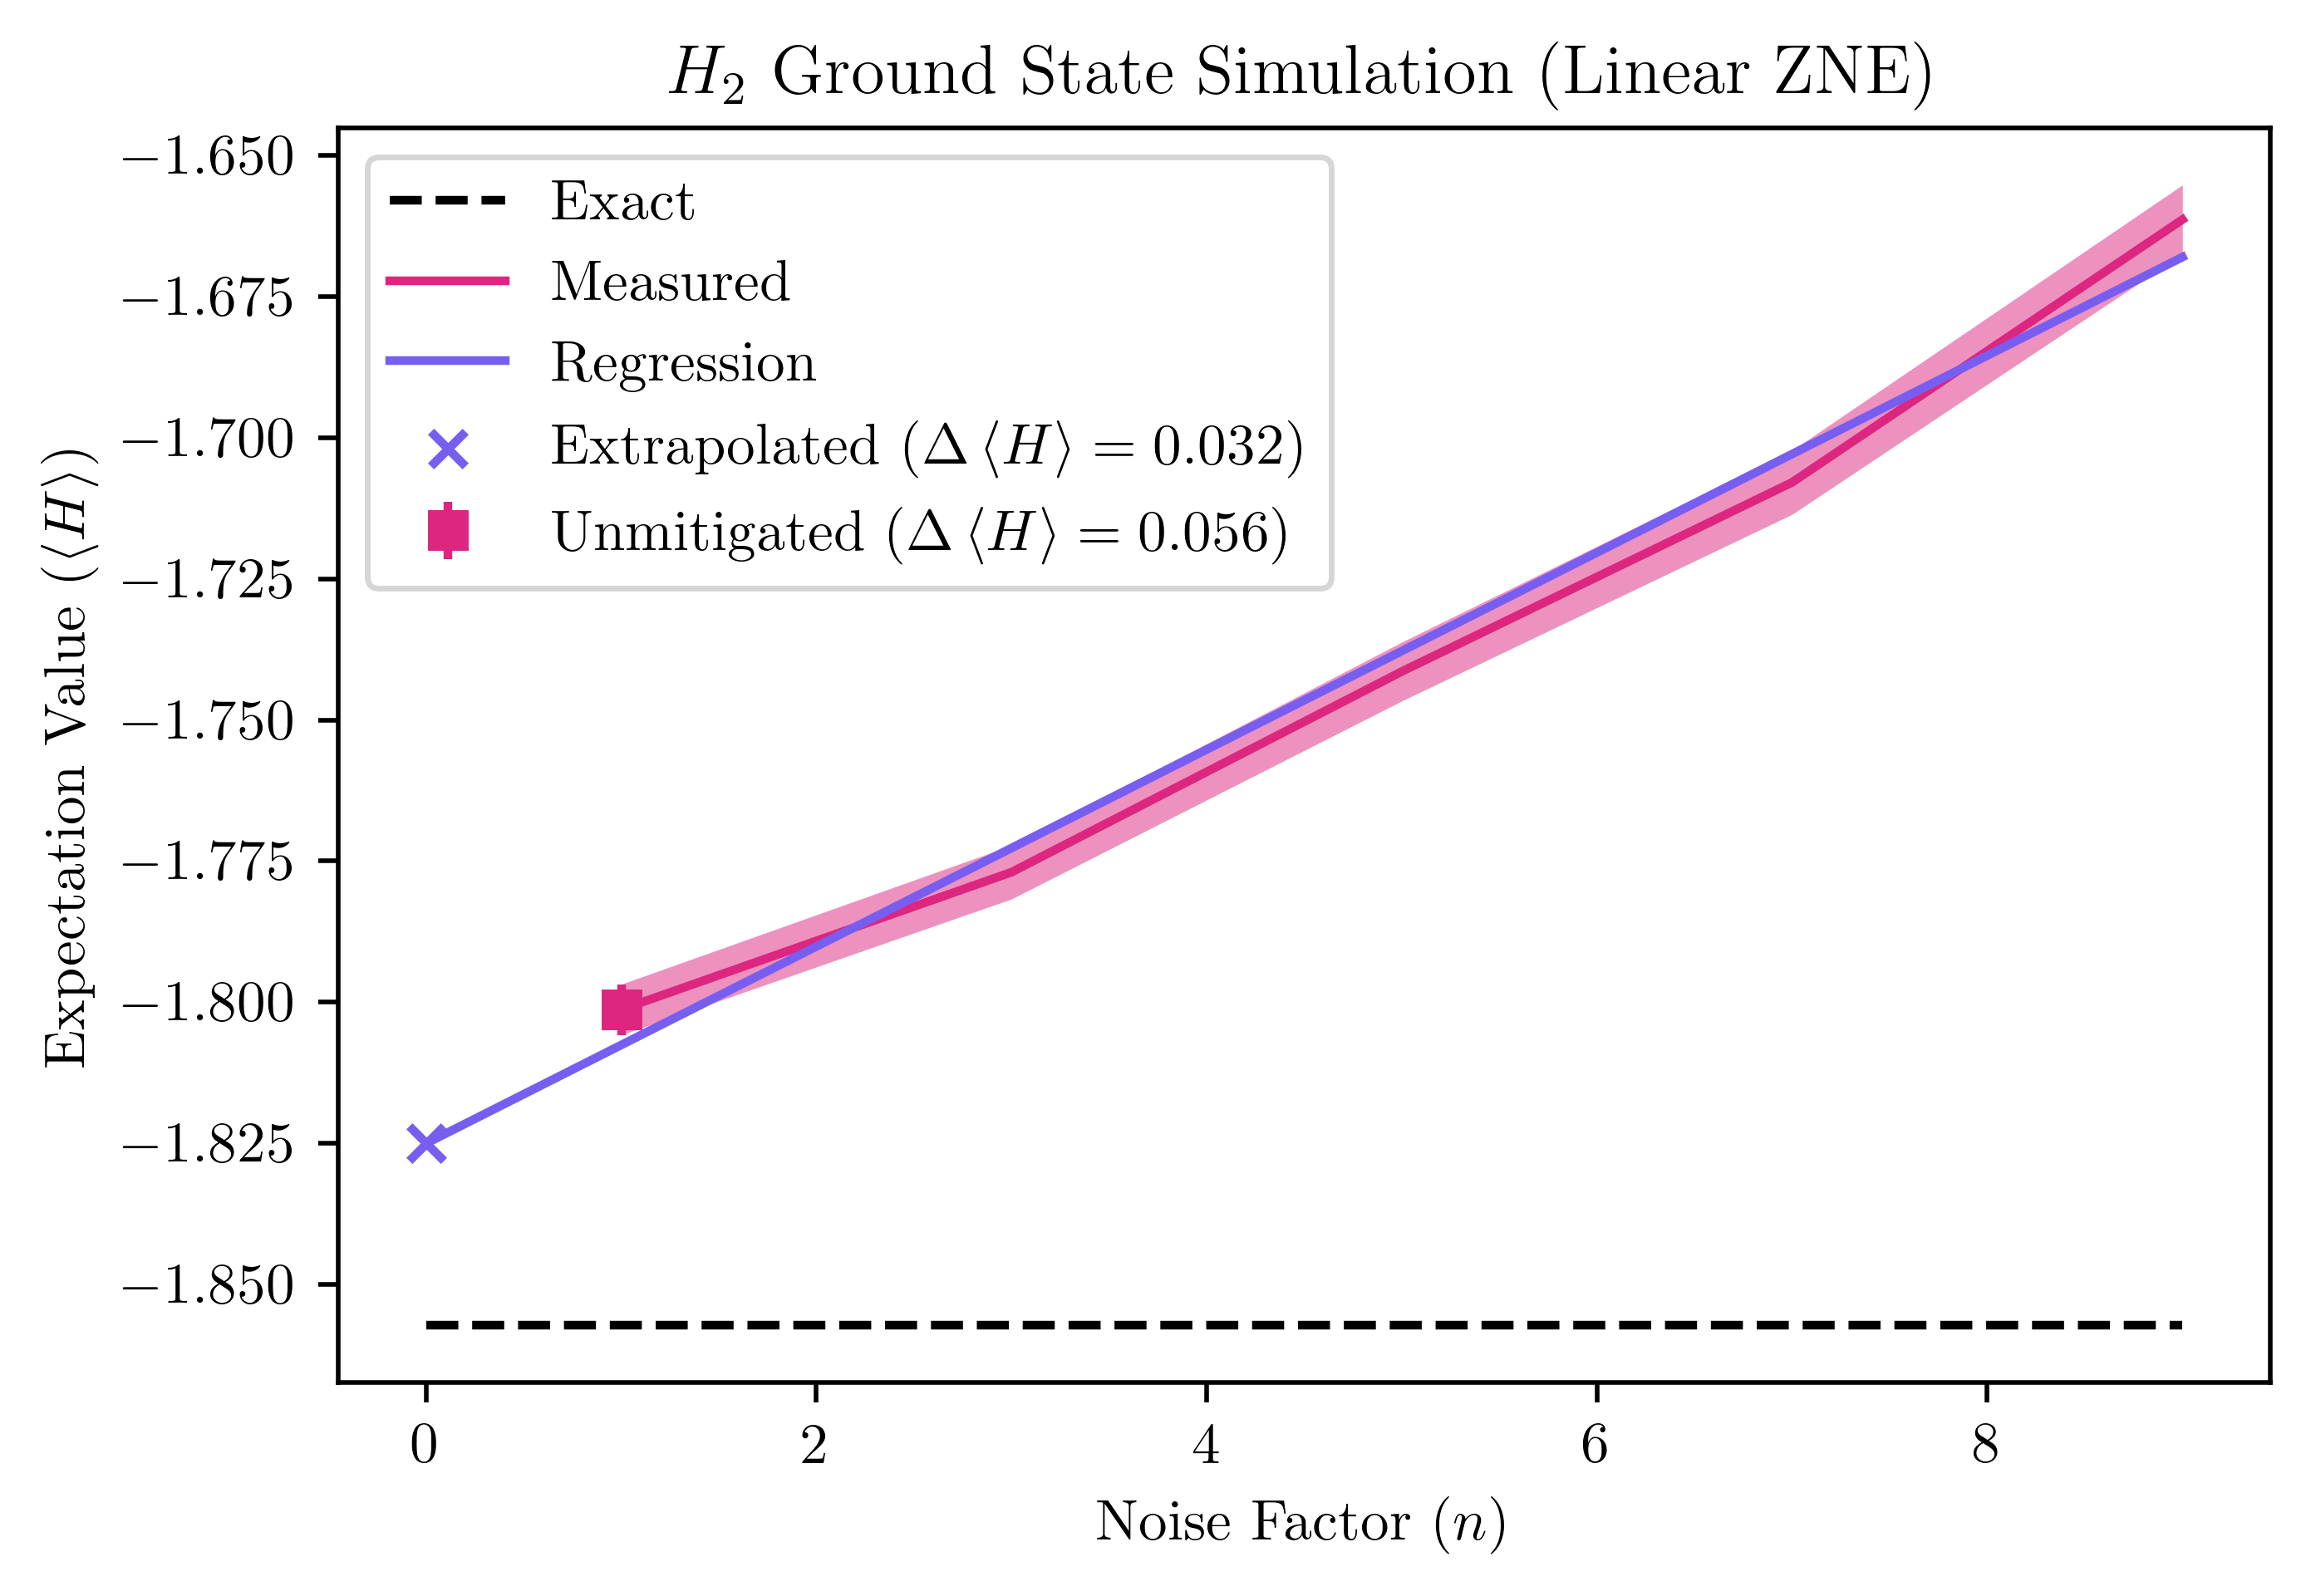

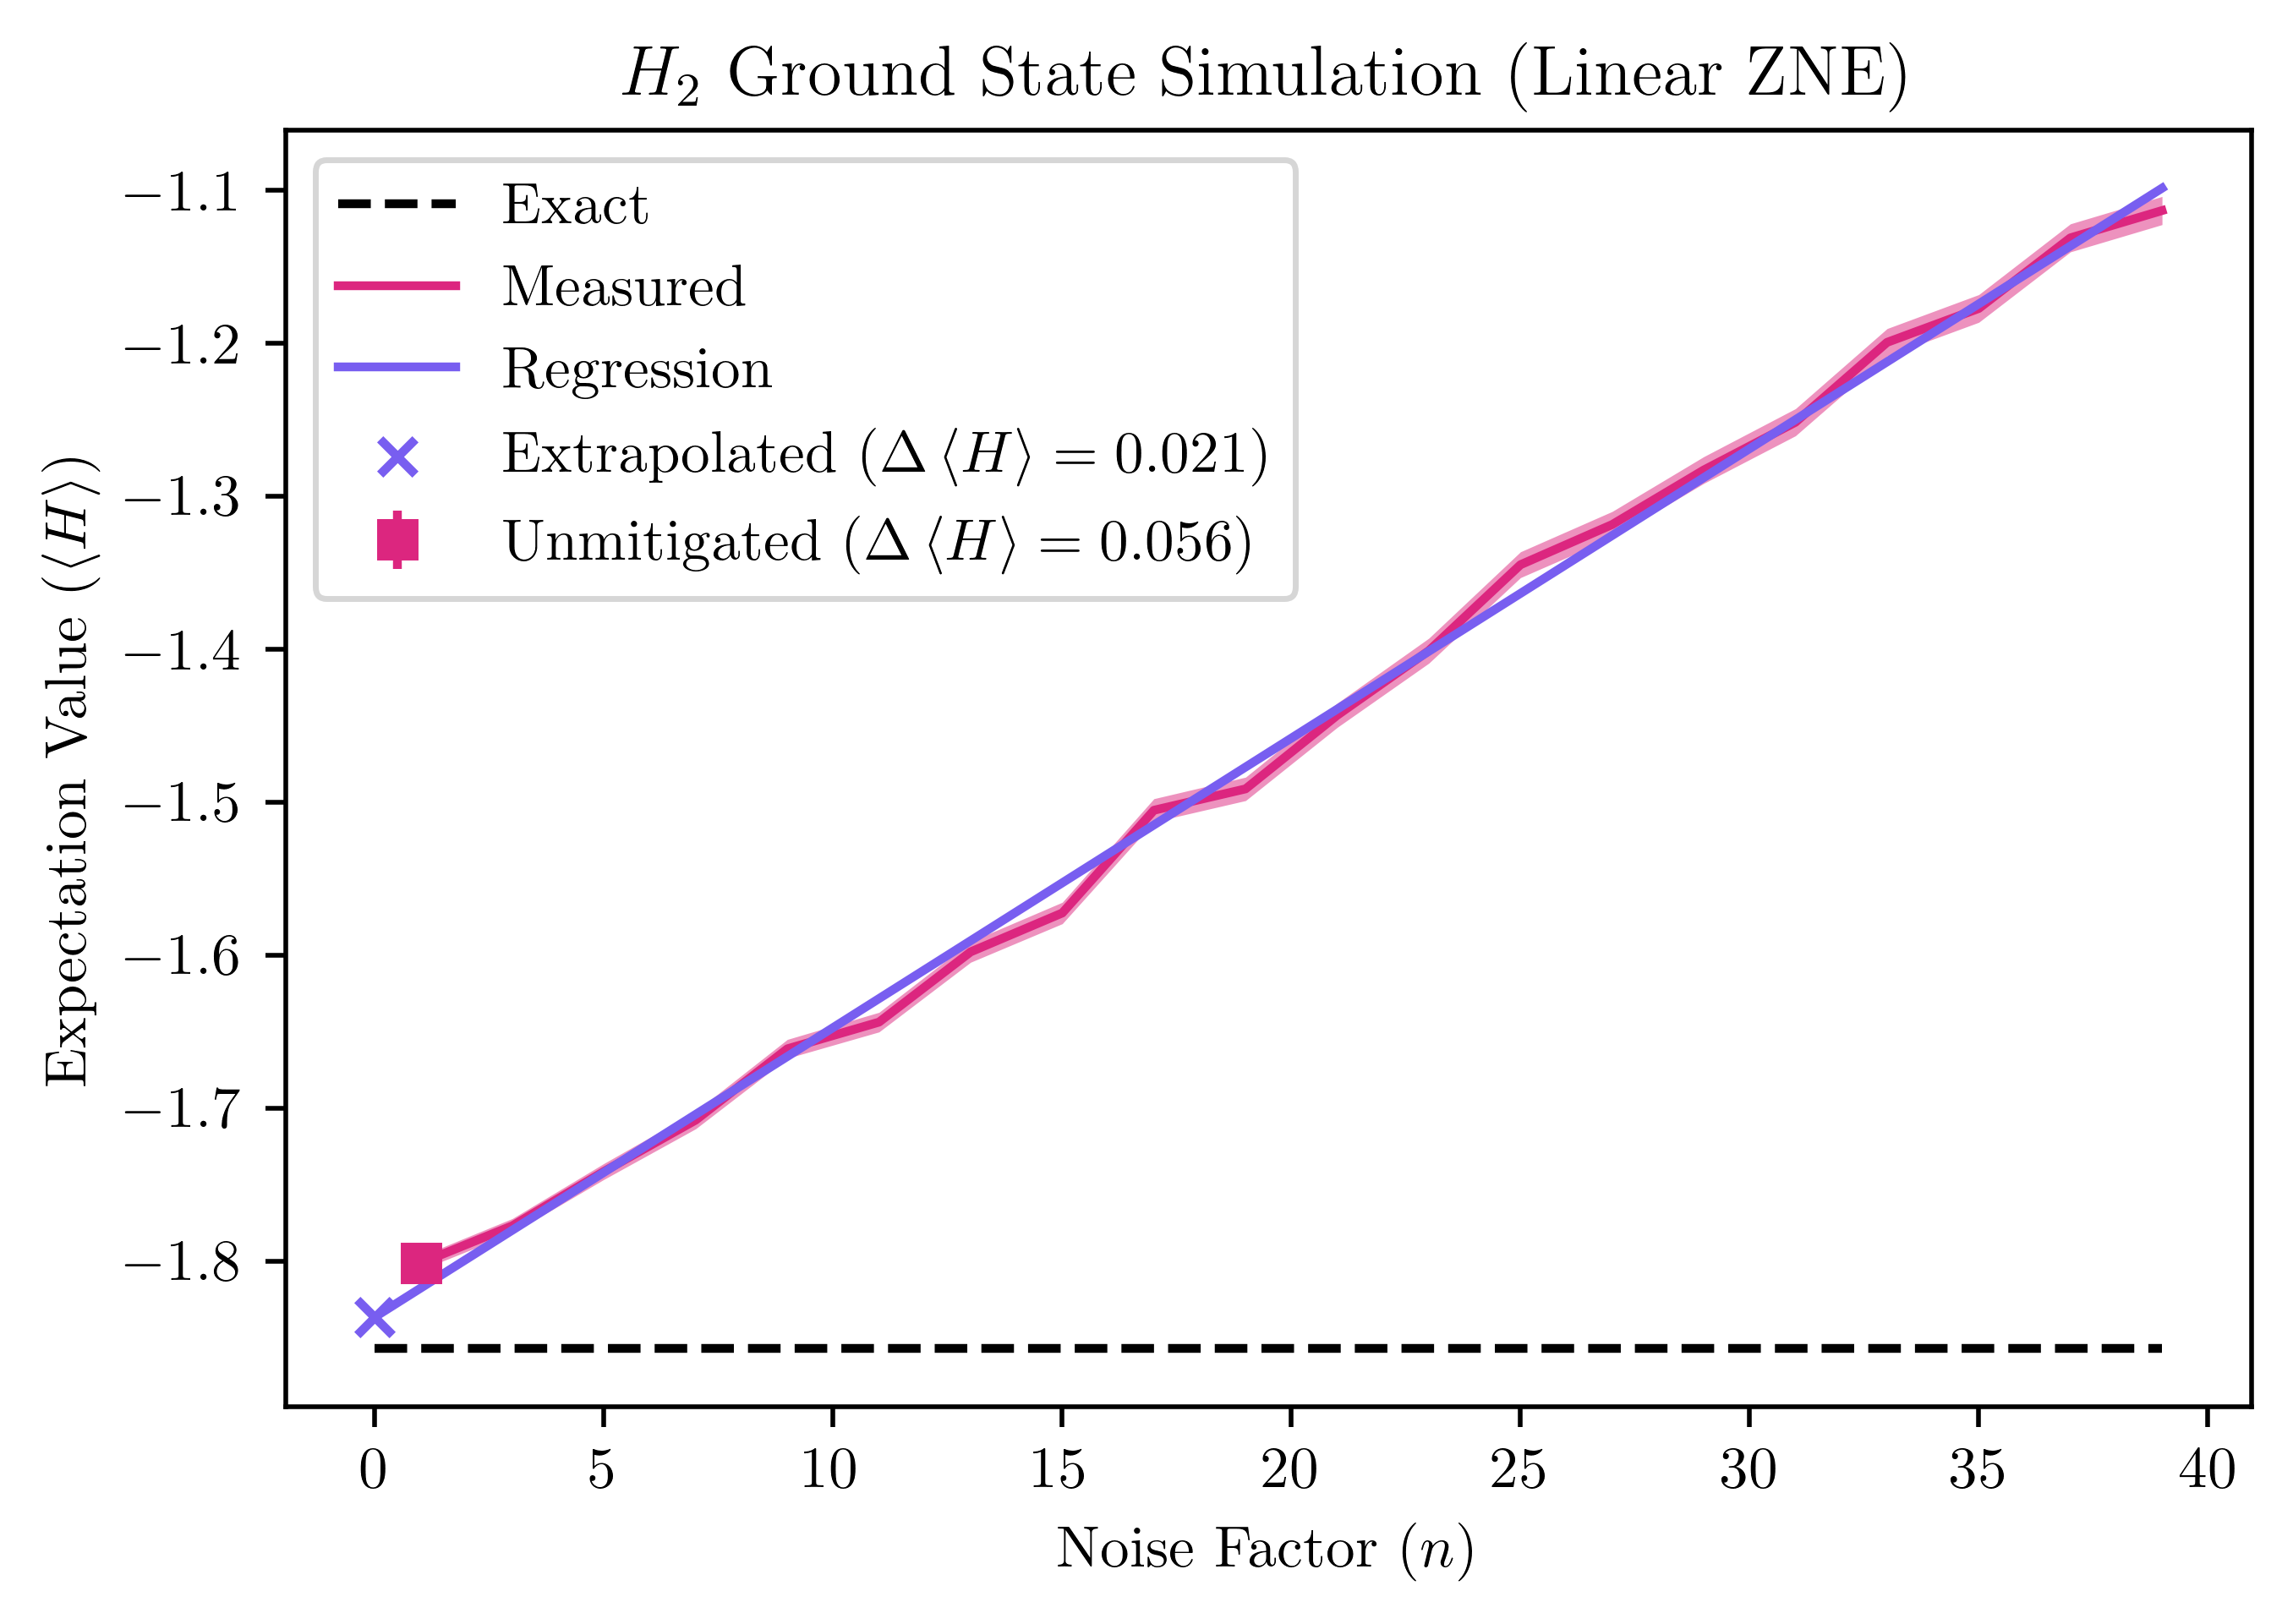

In [20]:
for regime in [3, 5, 20]:
    plot_results(data, H2_GNDSTATE_ENERGY, "$H_2$ Ground State Simulation (Linear ZNE)", "H", regime=regime, regression_model=linear)

Looks like the more of the linear regime we feed to our regression, the closer we extrapolate to the exact ground state energy!

### Damped Sinusoid Regression

Next up, let's try feeding all the data we have to a damped sinusoid regression. Once again, we start by defining the regression model.

In [11]:
def damped_sinusoid(noise_factor, noiseless_ev, amplitude, frequency, decay_rate):
    return noiseless_ev + amplitude * (
        1 - np.cos(frequency * noise_factor) * np.exp(-decay_rate * noise_factor)
    )

Now, let's extrapolate to zero noise and take at the results! Since the damped sinusoid regression takes many parameters, we'll pass the optimizer order-of-magnitude estimates on the parameters from looking at the curve to help it converge quicker:
* `noiseless_ev = data["values"][0]` (the unmitigated energy is a good order-of-magnitude guess for the noiseless energy).
* `amplitude = 0.8` (the sinusoid peaks around -1 which is 0.8 higher than where it starts around -1.8).
* `frequency = (2*np.pi)/(60*4)` (the sinusoid peaks around $n\approx 60$; multiplying by 4 gives an estimate on the period of the sinusoid).
* `decay_rate = 0.01` (the curve flattens out around $n\approx 100$).

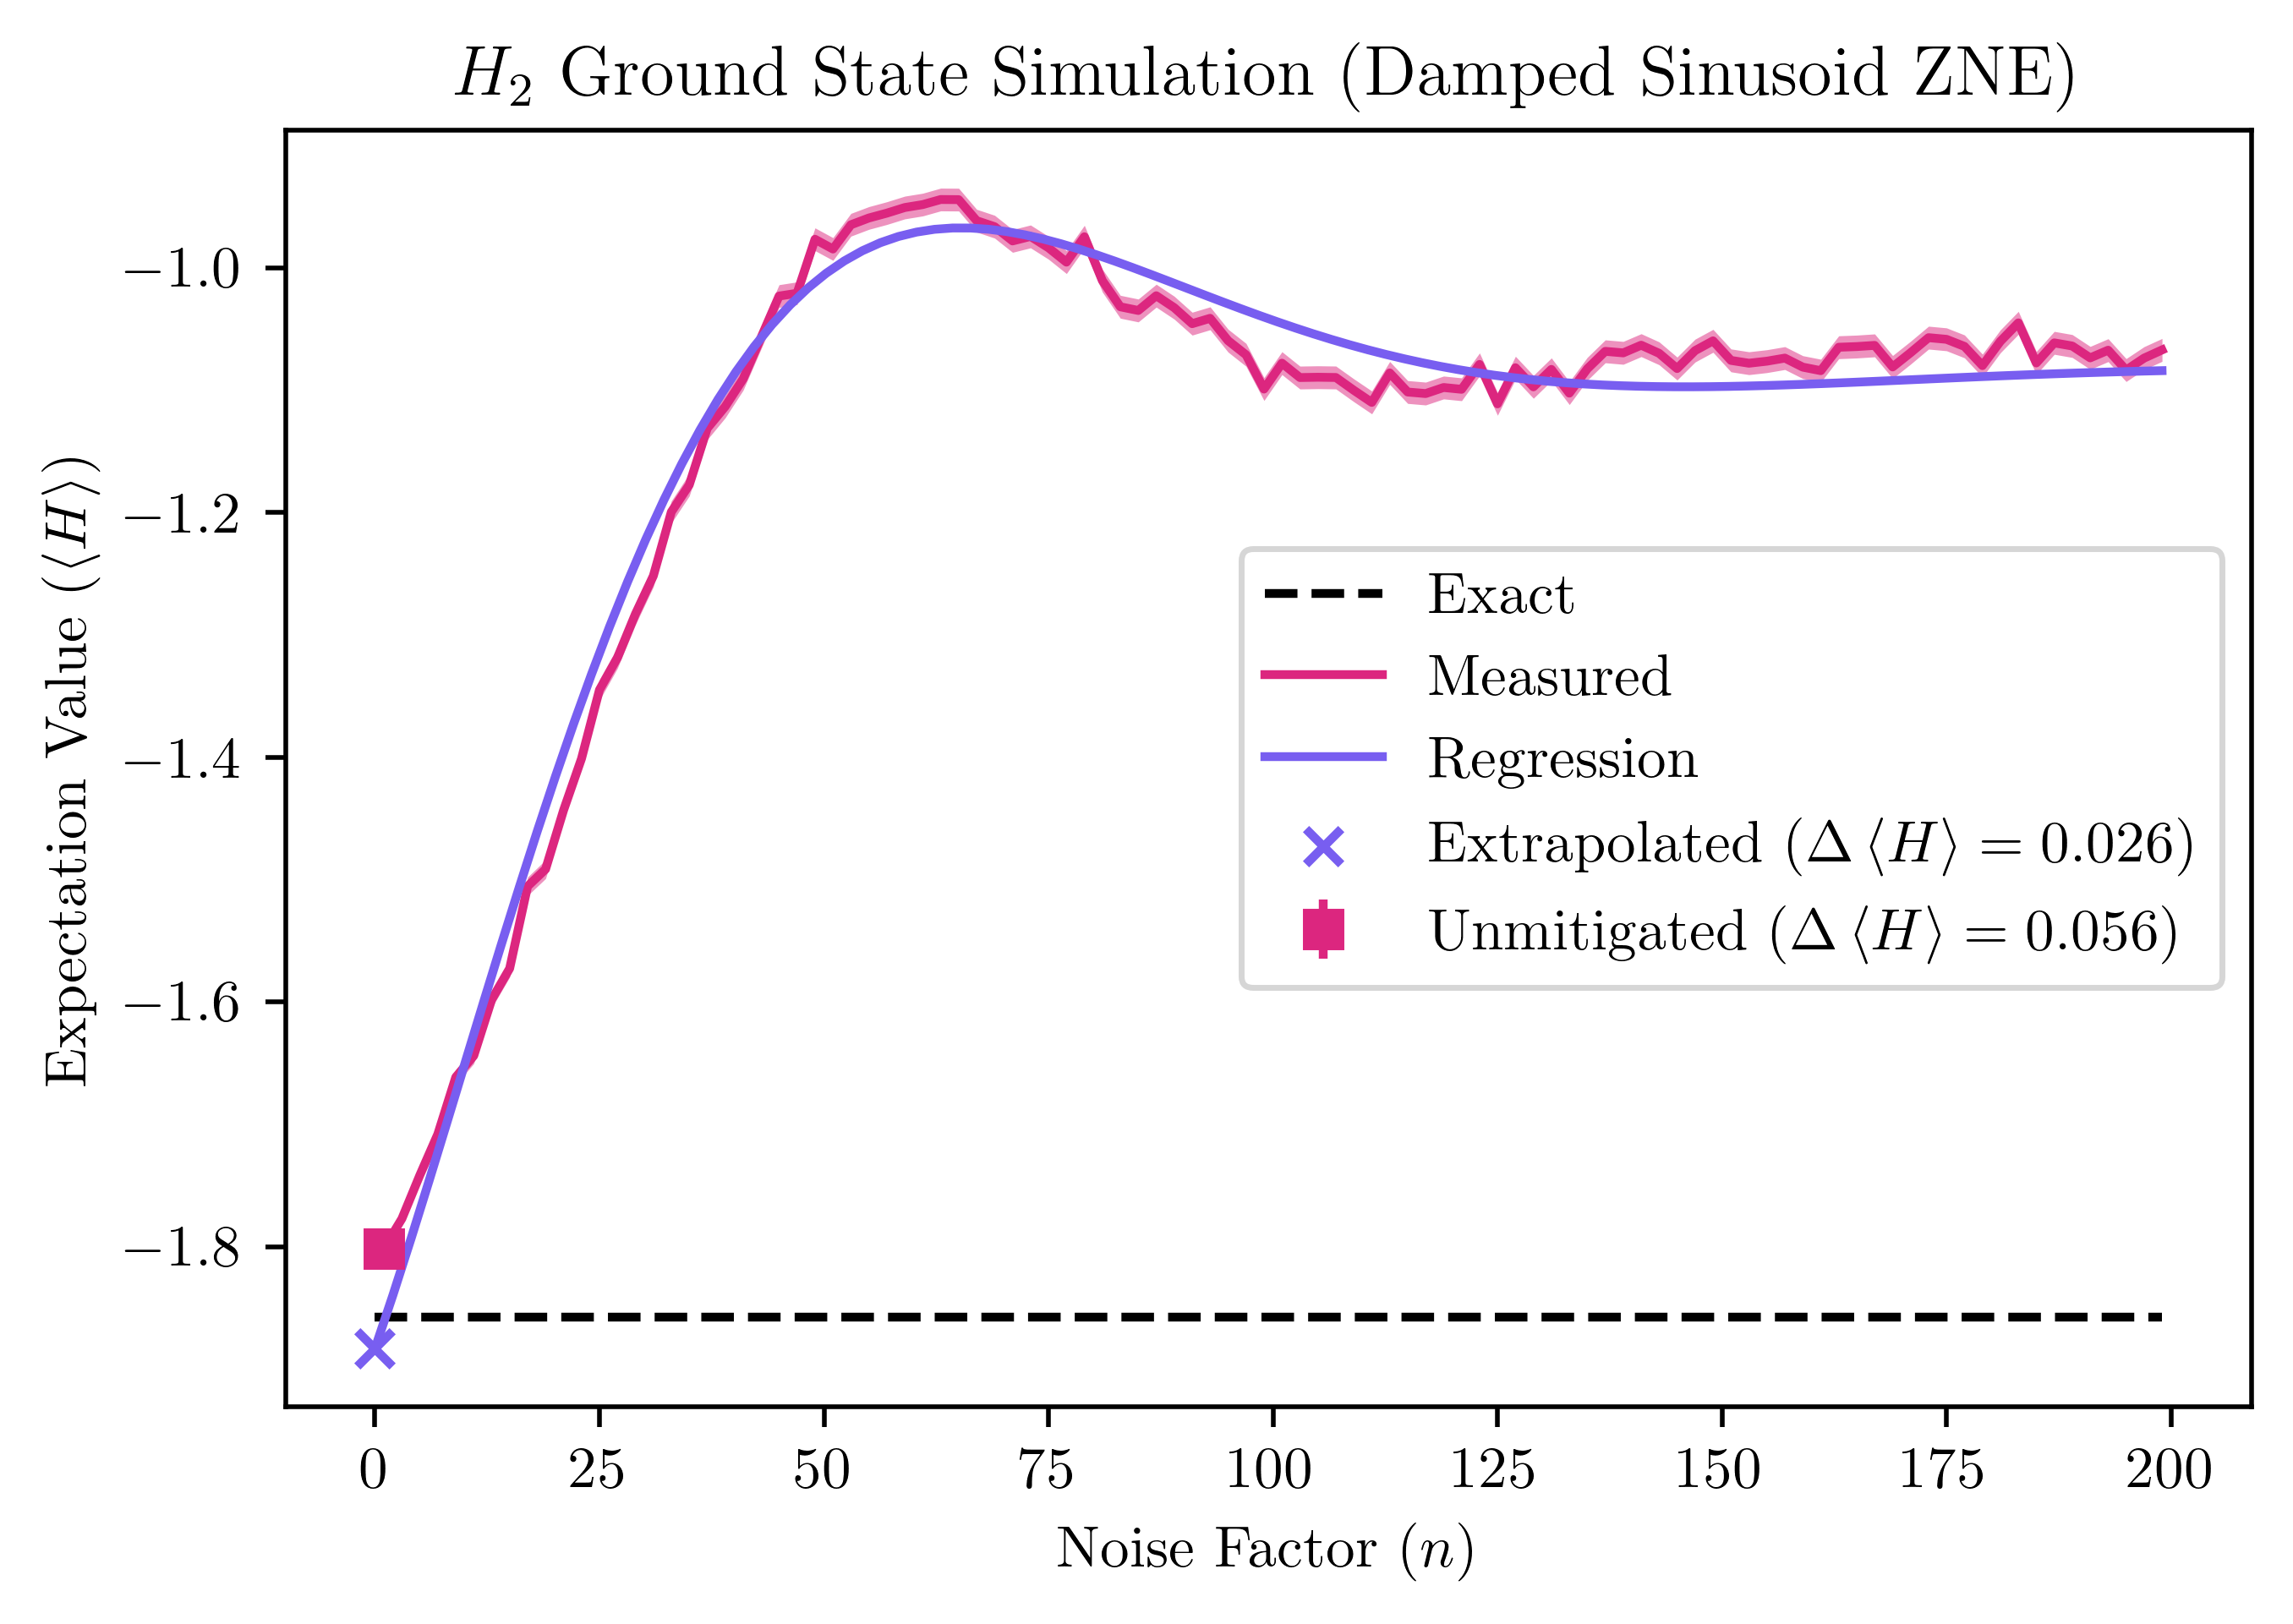

In [23]:
plot_results(data, H2_GNDSTATE_ENERGY, "$H_2$ Ground State Simulation (Damped Sinusoid ZNE)", "H", regression_model=damped_sinusoid, regression_guess=[data["values"][0], 1, (2*np.pi)/(60*4), 0.01])

Looks like we get a decent fit that gets about twice as close to the exact energy as the unmitigated expectation value!

Hopefully, you now have a sense of how to use zero-noise extrapolation to improve your own expectation value experiments.